In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz:str
    abc:str

In [3]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: str

def node(state:OverallState):
    return {"a":"Hi I am Krish"}

In [4]:
# Build the state graph
builder = StateGraph(OverallState)

builder.add_node(node)  # node_1 is the first node
builder.add_edge(START, "node")  # Start the graph with node_1
builder.add_edge("node", END)  # End the graph after node_1

graph = builder.compile()

In [5]:
graph.invoke({"a":"Hello"})

{'a': 'Hi I am Krish'}

In [6]:
try:
    graph.invoke({"a":123})  #should be a string,#i have given the integer , so that's why the error is here
except Exception as e:
    print("Exception was raised because a value iss integer")

c:\MY_Folder\MY_Courses\5.Agentic_AI_1.0_Batch\Code_Files\Agentic_env\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=123, input_type=int])
  return self.__pydantic_serializer__.to_python(


## Multiple Nodes- Run time validation

- Run-time validation will also work in a `multi-node graph`. In the example below `bad_node` updates a to an integer.

- Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [7]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

def bad_node(state: OverallState):
    return {
        "a": 123  # Invalid
    }

def ok_node(state:OverallState):
    return {"a":"goodbye"}

# Build the state graph
builder = StateGraph(OverallState)

builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)

graph = builder.compile()

In [8]:
# Test the graph with a valid input
try:
    graph.invoke({"a": "krish"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

c:\MY_Folder\MY_Courses\5.Agentic_AI_1.0_Batch\Code_Files\Agentic_env\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=123, input_type=int])
  return self.__pydantic_serializer__.to_python(


### Prompt Chaining
- `Prompt chaining` decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.


- `When to use this workflow:` This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

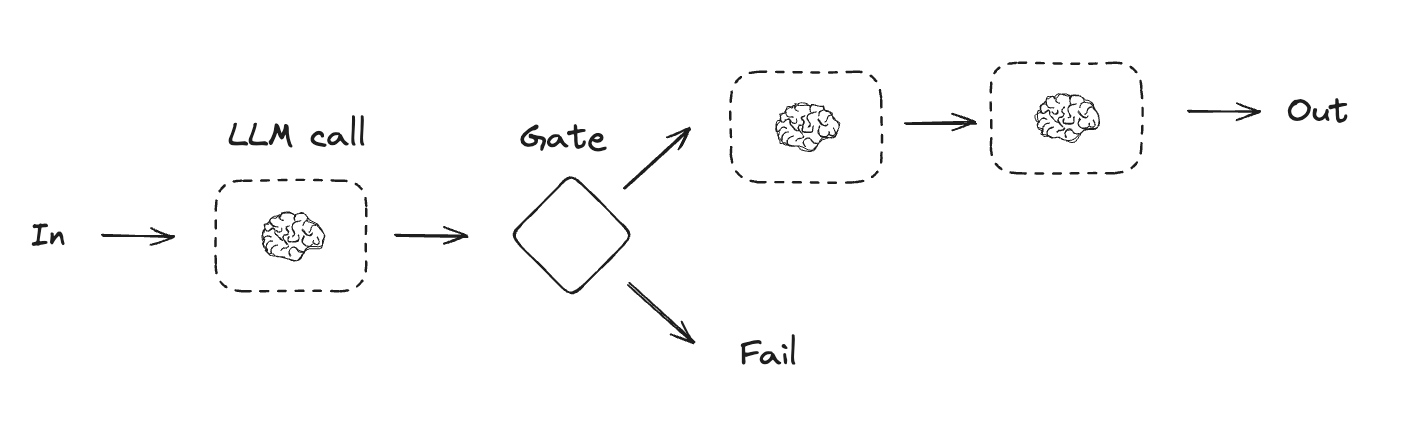

In [9]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


llm = ChatGroq(model="gemma2-9b-it")
#llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke("Hello")
result



AIMessage(content='Hello! 👋 \n\nHow can I help you today? 😄\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 11, 'total_tokens': 27, 'completion_time': 0.029090909, 'prompt_time': 0.001902327, 'queue_time': 0.264939953, 'total_time': 0.030993236}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-2eb6c4a9-e765-418b-9d99-1746ca04f5c5-0', usage_metadata={'input_tokens': 11, 'output_tokens': 16, 'total_tokens': 27})

In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [11]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



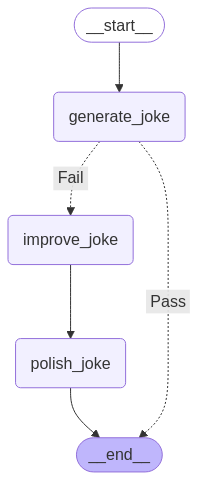

In [12]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [13]:
# Invoke
state = chain.invoke({"topic": "cats"})

In [14]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the jungle? \n\nToo many cheetahs!  \n",
 'improved_joke': "Why don't cats play poker in the jungle? \n\nToo many cheetahs!  They're always trying to **paw** their way to the win! \n\n\nLet me know if you'd like to try another round of joke-ifying! 😄 \n",
 'final_joke': 'That\'s a good one!  \n\nHere\'s a twist that plays on the classic "too many cooks spoil the broth" idea:\n\nWhy don\'t cats play poker in the jungle? \n\nToo many cheetahs!  They always want to **split the pot**, and nobody gets a proper stake! \n\n\nReady for another joke?  \n\n'}

In [15]:
state['improved_joke']

"Why don't cats play poker in the jungle? \n\nToo many cheetahs!  They're always trying to **paw** their way to the win! \n\n\nLet me know if you'd like to try another round of joke-ifying! 😄 \n"

In [16]:
state['final_joke']

'That\'s a good one!  \n\nHere\'s a twist that plays on the classic "too many cooks spoil the broth" idea:\n\nWhy don\'t cats play poker in the jungle? \n\nToo many cheetahs!  They always want to **split the pot**, and nobody gets a proper stake! \n\n\nReady for another joke?  \n\n'

### Parallelization¶
- With parallelization, LLMs work simultaneously on a task:

- LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: 
- `Sectioning`: Breaking a task into independent subtasks run in parallel. 
- `Voting`: Running the same task multiple times to get diverse outputs.

- When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

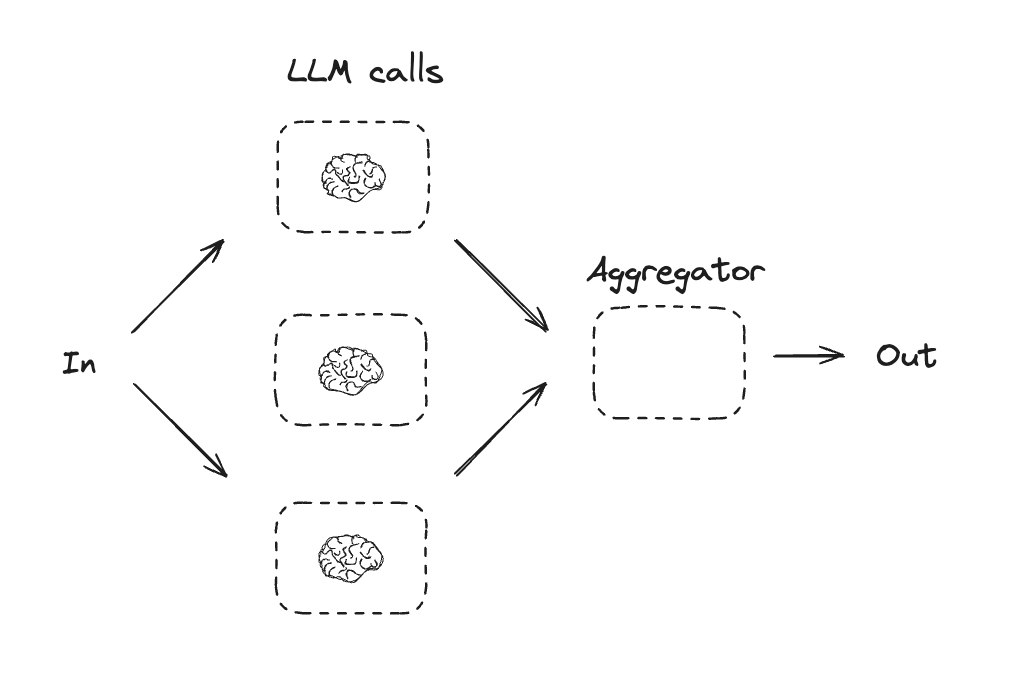

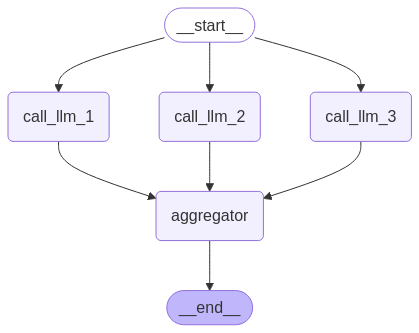

Here's a story, joke, and poem about cats!

STORY:
Clementine, a calico with mismatched socks and a perpetually grumpy expression, ruled the alley with an iron paw. She wasn't cruel, just efficient. Her domain stretched from the overflowing dumpster behind the pizzeria to the rickety fence bordering Mrs. Peabody's prize-winning rose bushes. 

One day, a ginger whirlwind named Marmalade crashed into Clementine's carefully curated world. He was young, impulsive, and everything Clementine wasn't. He bounced off walls, chased butterflies with reckless abandon, and constantly tried to engage Clementine in games of "tag" which she found utterly exhausting. 

"Must you be so...energetic?" Clementine grumbled one afternoon, swatting at Marmalade's tail as he attempted to weave between her legs.

Marmalade, unfazed, purred and rubbed against her flank. "But it's fun! Come on, Clementine, let loose! Life's too short to be grumpy all the time."

Clementine scoffed. "Life is about survival, Marmal

In [17]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

### Routing
- Routing classifies an input and directs it to a specialized followup task. 
- This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

- `When to use this workflow:` Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

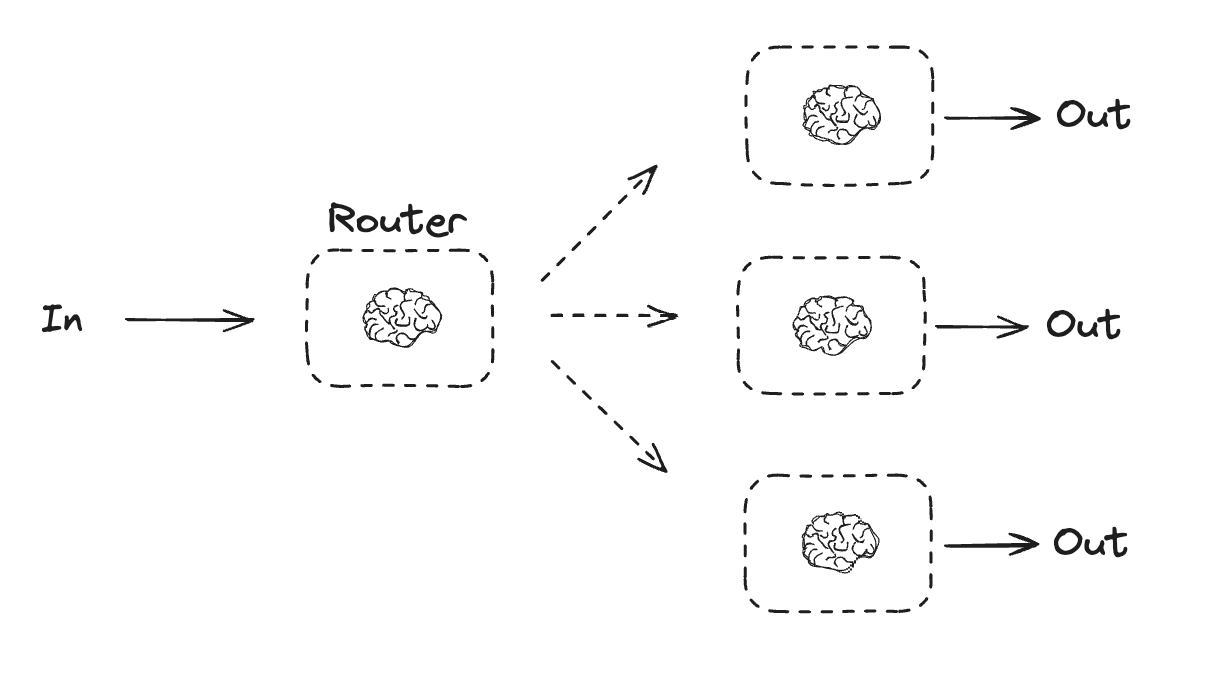

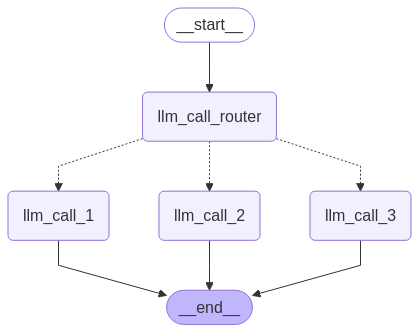

LLM call 2 is called
Why don't cats play poker in the jungle? 

Too many cheetahs! 😹 



In [18]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

### Orchestrator-Worker
- In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

- `When to use this workflow:` This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

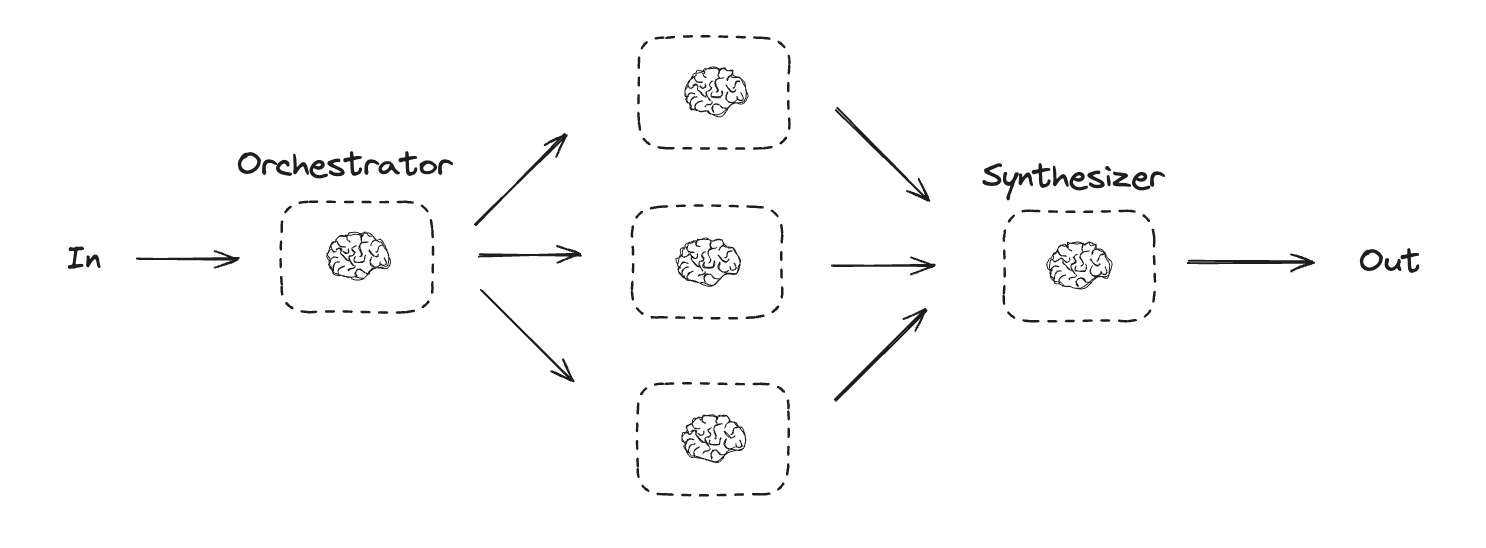

In [24]:

from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [21]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


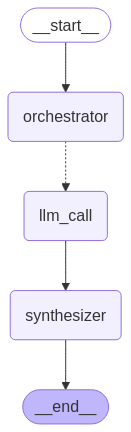

Report Sections: sections=[Section(name='Introduction', description='Introduction to Agentic AI RAGs: Define Agentic AI, explain the concept of RAGs, and highlight their importance in this context.'), Section(name='Capabilities', description='Capabilities and functionalities of Agentic AI RAGs: Discuss their ability to understand and respond to complex queries, generate creative content, and learn from user interactions.'), Section(name='Applications', description='Applications of Agentic AI RAGs: Explore real-world use cases across various industries, such as customer service, education, and research.'), Section(name='Ethical Considerations', description='Ethical considerations and challenges: Address potential biases, privacy concerns, and the need for responsible development and deployment.'), Section(name='Future Directions', description='Future directions and research: Discuss ongoing advancements, emerging trends, and potential future developments in Agentic AI RAGs.'), Section(n

## Introduction and description: Introduction to Agentic AI RAGs

Agentic AI refers to artificial intelligence systems that can act autonomously, make decisions, and take actions in the world to achieve specific goals. These systems possess a degree of autonomy and goal-directed behavior, distinguishing them from traditional AI systems that primarily focus on data processing and prediction. 

Retrieval Augmented Generation (RAG) models combine the capabilities of language models with external knowledge sources. They leverage retrieval mechanisms to access and incorporate relevant information from these sources, enhancing their ability to generate more accurate, comprehensive, and contextually relevant responses.  

In the context of Agentic AI, RAGs play a crucial role by enabling agents to access and utilize vast amounts of external knowledge to make informed decisions and execute tasks effectively. This integration of knowledge retrieval with autonomous decision-making empowers agentic AI systems to operate more intelligently and adapt to complex, dynamic environments. 


---

## Capabilities and Functionalities of Agentic AI RAGs

Agentic AI RAGs demonstrate advanced capabilities in understanding and responding to complex queries. Leveraging their extensive knowledge base and powerful language models, they can decipher nuanced questions, identify relevant information, and synthesize comprehensive answers.  Beyond retrieving information, these RAGs are capable of generating creative content such as stories, poems, and even code, showcasing their generative capabilities. 

Furthermore, Agentic AI RAGs possess a unique ability to learn and adapt from user interactions. By analyzing user queries, feedback, and context, they can refine their understanding of user needs and preferences, leading to more accurate and personalized responses over time. This continuous learning loop enables Agentic AI RAGs to evolve and become increasingly sophisticated in their interactions with users.  


---

## Applications and Use Cases

Agentic AI RAGs find applications across a wide range of industries, revolutionizing how businesses and individuals interact with information.

**Customer Service:**

* **Chatbots:**  RAGs power intelligent chatbots that can understand complex customer queries, access vast knowledge bases to provide accurate answers, and even resolve simple issues autonomously. This frees up human agents to handle more complex cases, improving customer satisfaction and efficiency.
* **Personalized Support:** RAGs can analyze customer interactions and preferences to deliver personalized support experiences. They can recommend relevant products or services, offer tailored solutions, and anticipate customer needs.

**Education:**

* **Intelligent Tutors:** RAGs can act as personalized tutors, providing students with customized learning experiences. They can answer questions, explain concepts, offer practice exercises, and track student progress.
* **Research Assistance:**  RAGs can assist students and researchers in finding relevant information from vast academic databases, summarizing research papers, and identifying key insights.

**Research:**

* **Scientific Discovery:** RAGs can analyze scientific literature, identify patterns and trends, and generate hypotheses for further research. They can accelerate the pace of scientific discovery by providing researchers with a powerful tool for knowledge exploration.
* **Data Analysis:** RAGs can process and analyze large datasets, identifying valuable insights and patterns that may be difficult for humans to discern. This can be applied to various fields, including healthcare, finance, and market research.


These are just a few examples of the many ways Agentic AI RAGs are transforming industries. As this technology continues to evolve, we can expect to see even more innovative applications emerge, further enhancing our ability to access, understand, and utilize information.

---

## Ethical Considerations and Challenges 

This project raises several ethical considerations and challenges that must be carefully addressed. 

**Bias:**  Like all machine learning models, our system is susceptible to biases present in the training data. This could result in discriminatory or unfair outcomes, perpetuating existing social inequalities. We will mitigate this risk through careful selection of diverse and representative training datasets, rigorous testing for bias, and ongoing monitoring for unintended consequences.

**Privacy:** The project may involve the processing of sensitive personal data. We are committed to protecting user privacy by implementing strong data anonymization techniques, obtaining informed consent for data usage, and adhering to all relevant privacy regulations.

**Responsible Development and Deployment:** We recognize the potential impact of our technology and are committed to developing and deploying it responsibly. This includes:

* **Transparency:** Making the model's workings and limitations clear to users.
* **Accountability:** Establishing clear lines of responsibility for the system's outputs and potential consequences.
* **Fairness:**  Ensuring the system treats all users equitably and does not discriminate against any group.
* **Safety:**  Designing the system to be robust and reliable, minimizing the risk of harm.
* **Sustainability:**  Considering the environmental impact of the system's development and operation. 


We will actively engage with stakeholders, including ethicists, policymakers, and the general public, to ensure that the development and deployment of this project aligns with ethical principles and societal values. 


---

## Future Directions and Research

Ongoing research in Agentic AI RAGs is focused on several key areas:

* **Enhanced Reasoning and Planning:**  Developing RAGs with stronger reasoning and planning capabilities will enable them to autonomously navigate complex environments and accomplish intricate tasks. This involves exploring novel architectures and algorithms inspired by cognitive science and symbolic AI.
* **Multi-modal Interaction:** Integrating multiple modalities, such as vision, audio, and tactile sensing, will make RAGs more versatile and human-like. This requires advancements in sensor fusion, multimodal understanding, and generation.
* **Personalized and Adaptive Learning:** Tailoring RAGs to individual user needs and preferences will enhance their usability and effectiveness. Research is being conducted on personalized learning algorithms, user modeling, and adaptive interfaces.
* **Explainable and Trustworthy AI:**  Increasing transparency and interpretability in RAG decision-making processes is crucial for building trust and accountability.  Efforts are underway to develop techniques for explaining RAG actions, identifying potential biases, and ensuring ethical considerations are addressed.
* **Scalability and Efficiency:**  Training and deploying large-scale RAG models can be computationally expensive. Research is exploring efficient training methods, model compression techniques, and distributed learning architectures to address these challenges.


These advancements will pave the way for more sophisticated and impactful Agentic AI RAGs, capable of assisting humans in a wider range of domains, from everyday tasks to complex scientific research. 


---

## Conclusion

This report has explored the rapidly evolving landscape of Agentic AI Retrieval Augmented Generation (RAG) systems. Key takeaways include the significant advancements in incorporating reasoning and planning capabilities into RAG models, enabling them to move beyond simple text generation and engage in more complex, goal-oriented interactions. The transformative potential of Agentic AI RAGs is undeniable, promising to revolutionize how we interact with information and automate complex tasks.  Their ability to access and process vast datasets, reason about information, and plan actions opens doors to unprecedented levels of intelligence and efficiency in various domains, from research and education to customer service and creative industries. As research and development in this field continue, we can expect to see even more sophisticated and impactful applications of Agentic AI RAGs, shaping the future of artificial intelligence and its role in our lives.  


In [23]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

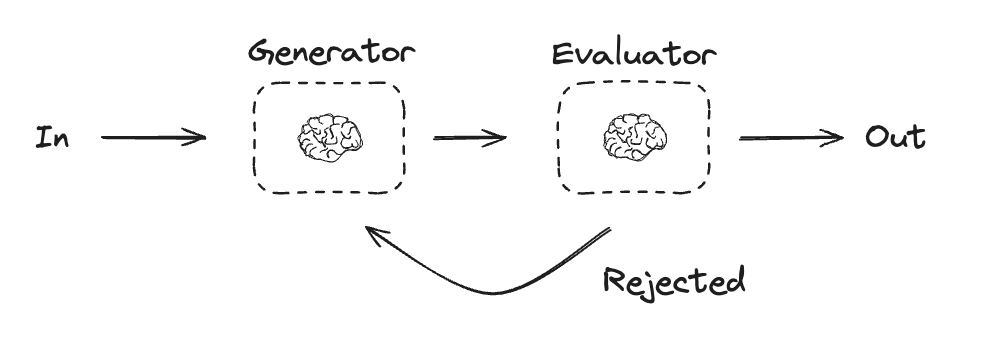

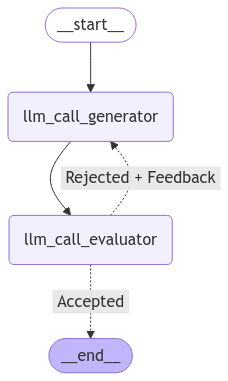

Why don't cats play poker in the wild? Because there are too many cheetahs!


In [30]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])